In [1]:
from desc import set_device
set_device("gpu")

/home/fcastro/DESC/desc/__init__.py:98: UserWarning: No GPU found, falling back to CPU
  warnings.warn(colored("No GPU found, falling back to CPU", "yellow"))


In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface, FourierXYZCurve
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list, Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot


from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64
Using device: CPU, with 159.44 GB available memory


In [3]:
M = 10
N = 10

egrid = LinearGrid(M = 10, N = 10, NFP = 1)

In [4]:
theta = egrid.nodes[:,1]
zeta = egrid.nodes[:,2]

In [5]:
a = 5
b = 1
c = 2

d = 2

e = 5
f = - 1/2
g = 2

# Z position in cylindrical coordinates
z_vals = ( e * np.cos(theta) + f * np.sin(g * theta) )

# Radial position from the origin, not exactly radial position in cylindrical coordinates
r_vals = ( ( a + b * np.sin(theta) + c * np.cos( d * theta) ) ** 2 
            + z_vals ** 2
            ) ** (1/2)

fake_theta = np.arctan(z_vals / r_vals)

x_vals =  r_vals * np.cos(fake_theta) * np.cos(zeta)
y_vals = r_vals * np.cos(fake_theta)  * np.sin(zeta)

# Radial position in cylindrical coordiantes
R_vals = (x_vals**2 + y_vals**2)**(1/2)

# XYZ coordinates of the surface
coordsx = np.vstack((x_vals, y_vals,z_vals)).T

In [6]:
# R, phi, Z coordinates of the surface (cylindrical)
coords = np.vstack((R_vals, zeta,z_vals)).T

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

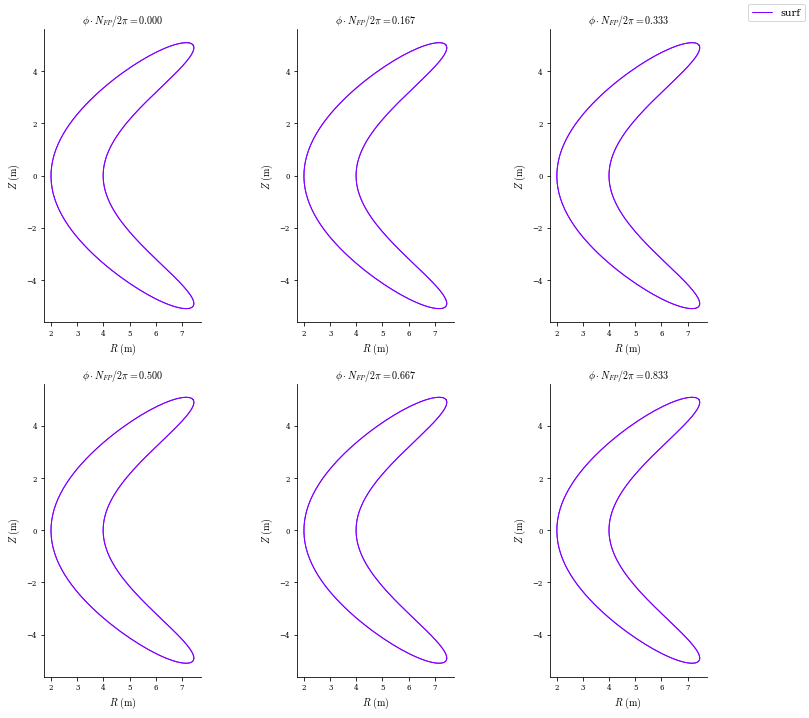

In [7]:
surf = FourierRZToroidalSurface.from_values(coords,
                                            theta = theta,
                                            M=6,
                                            N=6,
                                            NFP=1,
                                            sym=False,
                                            )

plot_comparison([surf],labels=["surf"],theta=0, rho=np.array(1.0))

In [8]:
eq = Equilibrium(surface = surf)

<class 'numpy.ndarray'>


/home/fcastro/DESC/desc/equilibrium/initial_guess.py:226: UserWarning: Surfaces from initial guess are not nested, attempting to refine coordinates. This may take a few moments.
  warnings.warn(


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.ArrayImpl'>


In [ ]:
surf = eq.get_surface_at(zeta=0)
eq0 = Equilibrium(surface=surf, N=0)
plot_surfaces(eq0)